## Objective

The main objective of this challenge is to predict trip time for shoppers who deliver groceries to customers.
Also Identify ways of improving the trip times and what factors that impact

## Data

trips (train +  test): contains trip information - id, shopper_id, store_id, trip start/end time
orders: contains order information - trip_id, item_id, department and quantity 

In [354]:
# Import all modules
import pandas as pd
import numpy as np
import seaborn as sns
sns.reset_orig()

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ElasticNetCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from functools import reduce

## 1. Import Data

In [355]:
# Importing data
orders_df = pd.read_csv("../data/order_items.csv")
train_df = pd.read_csv("../data/train_trips.csv", parse_dates=[4,5])
test_df = pd.read_csv("../data/test_trips.csv", parse_dates=[4])

In [356]:
test_df.head()

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at
0,4310899,60930,model_2,123,2015-11-16 07:00:12
1,4310904,59815,model_2,123,2015-11-16 07:00:12
2,4310907,60878,model_2,123,2015-11-16 07:00:13
3,4310911,60879,model_2,123,2015-11-16 07:00:13
4,4310328,66726,model_1,1,2015-11-16 07:01:08


In [357]:
train_df.head()

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at
0,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56
1,3119513,3775,model_1,1,2015-09-01 07:04:33,2015-09-01 07:40:33
2,3119516,4362,model_1,1,2015-09-01 07:23:21,2015-09-01 07:41:21
3,3119792,47659,model_1,1,2015-09-01 07:29:52,2015-09-01 08:55:52
4,3119922,11475,model_1,1,2015-09-01 07:32:21,2015-09-01 09:01:21


In [358]:
orders_df.head()

,trip_id,item_id,department_name,quantity
0,3119513,368671,Produce,10.0
1,3120462,368671,Produce,10.0
2,3120473,368671,Produce,10.0
3,3121910,368671,Produce,6.0
4,3122332,368671,Produce,10.0


In [359]:
# Checking the level of the data-set
assert(orders_df.groupby(["trip_id","item_id"]).trip_id.count().nunique() == 1)
assert(train_df.trip_id.nunique() == train_df.shape[0])

#### LEVEL OF DATA

Here we have two data sets:
* **orders_df**: This dataset contains orders for all trips (Train and Test). Is contains information of items purchased for each trip. Therefore is unique at trip_id x item_id level

* **train_df**: This dataset is at trip_id level and contains information of individual trips - shopper that made the trip, store_id, start_time and end_time. There is another variable called fulfillment model which I was not clear about what it meant.

Let's create a column that tells us train and test trips in the orders dataset, just incase we need it

In [360]:
orders_df['data'] = 'None'
orders_df.loc[orders_df['trip_id'].isin(train_df.trip_id.unique()), 'data'] = 'train'
orders_df.loc[orders_df['trip_id'].isin(test_df.trip_id.unique()), 'data'] = 'test'


In [361]:
orders_df.data.unique()

array(['train', 'test'], dtype=object)

## 2. Data Cleaning and EDA

**Checking for nulls and missing values:**

In [362]:
# Check for nulls or missing values in orders
assert(orders_df[orders_df.quantity.isnull()].shape[0] == 0)
assert(orders_df[orders_df.department_name.isnull()].shape[0] == 0)
assert(orders_df[orders_df.item_id.isnull()].shape[0] == 0)
assert(orders_df[orders_df.trip_id.isnull()].shape[0] == 0)

In [363]:
assert(train_df[train_df.shopper_id.isnull()].shape[0] == 0)
assert(train_df[train_df.fulfillment_model.isnull()].shape[0] == 0)
assert(train_df[train_df.store_id.isnull()].shape[0] == 0)

There are no missing or null values in the dataset. 

**Checking duplicate items in the same trip**

In [364]:
(orders_df.groupby("trip_id").item_id.count() - orders_df.groupby("trip_id").item_id.nunique()).unique()

array([0], dtype=int64)

No duplicate items in the same trip

** Checking if > 1 store visited in the same trip**

In [365]:
train_df.groupby("trip_id").store_id.count().unique()

array([1], dtype=int64)

exactly 1 store visited in every visit

In [366]:
print("number of unique trips: ", orders_df.trip_id.nunique())

number of unique trips:  128710


In [367]:
print("Number of trips given in the training data: ", train_df.trip_id.nunique())

Number of trips given in the training data:  117063


In [368]:
orders_df.dtypes

trip_id              int64
item_id              int64
department_name     object
quantity           float64
data                object
dtype: object

In [369]:
train_df.dtypes

trip_id                         int64
shopper_id                      int64
fulfillment_model              object
store_id                        int64
shopping_started_at    datetime64[ns]
shopping_ended_at      datetime64[ns]
dtype: object

## Univariate Analysis

Let us look at the distributions of the given data. It is important to note that the distributions for orders data set include all trips (both train and test).

### 1. Items purchased per Trip

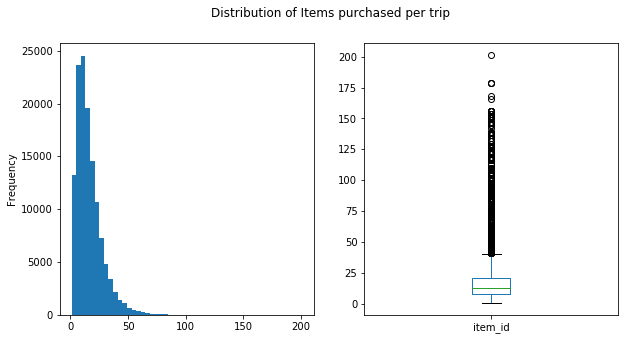

In [370]:
# Mumber of items per trip
fig = plt.figure(figsize=(10,5))

# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig.add_subplot(121)

# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig.add_subplot(122)

orders_df.groupby(["trip_id"]).item_id.nunique().plot(kind = "hist", bins = 50,ax = ax1)
orders_df.groupby(["trip_id"]).item_id.nunique().plot(kind = "box", ax = ax2)

fig.suptitle("Distribution of Items purchased per trip")
plt.show()

We do see quite a few outlier trips in terms of number of items purchased.These outliers are not significantly higher than the rest of the values. So let's keep them for now.

### 2. Quantity of Items per Trip

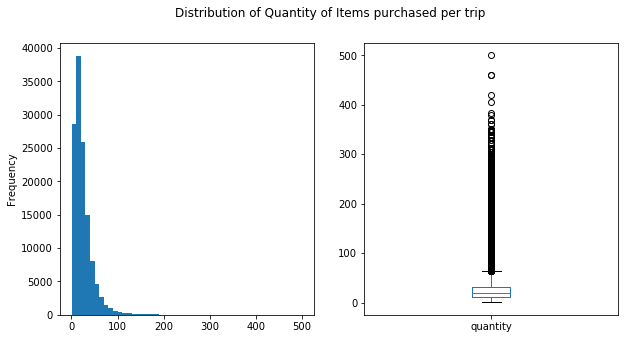

In [371]:
# Mumber of items per trip
fig = plt.figure(figsize=(10,5))

# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig.add_subplot(121)

# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig.add_subplot(122)

orders_df.groupby("trip_id").quantity.sum().plot(kind = "hist", bins = 50, ax = ax1)
orders_df.groupby("trip_id").quantity.sum().plot(kind = "box", ax = ax2)

fig.suptitle("Distribution of Quantity of Items purchased per trip")
plt.show()

Let's look into different departments from which products are puchased

In [372]:
# Unique departments
for dep in orders_df.department_name.unique():
    print(dep)

Produce
Snacks
Popular
Dairy & Eggs
Deli
Beverages
Pantry
International
Canned Goods
Household
Dry Goods & Pasta
Bakery
Meat & Seafood
Breakfast
Frozen
Smoothie Central
Babies
Alcohol
Personal Care
Valentine's Day Specials
Ice Cream Social!
Bulk
St. Patrick's Day Specials
Holiday Favorites
Our Brands
All It Takes to Bake!
25% OFF Supplements 8/14-8/16
Fill the Grill
Thanksgiving
Thanksgiving A to Z
Pets
Floral
Holidays
Newly Added
Holiday Essentials
Halloween
Local
Burning Man Essentials
Academy Awards
Bi-Rite Creamery
Valentine's- Made with Love!
New Year's Eve Extravaganza!
FitMarket
4th of July
TEST SPECIAL AISLE
Dog
Healthy Eating
Cheese
Cat
Aquatics
Summer Drinks
Super Bowl Party
Healthy Choices for 2016
Local Favorites
Father's Day
Mother's Day
Business Items
Game Day Specials
Olives, Gourmet Cheese, Salads
Passover & Easter
Ready to Eat
Gifts for the Foodie
Bi-Rite's Winter Favorites!
Bird
Travel
Fromagerie
BBQ Favorites
Hanukkah
Ready to Cook
Buyers' Picks
Small Animal
Vitamins

In [373]:
print("Number of departments in total: ", orders_df.department_name.nunique())
print("Number of departments in train: ", orders_df[orders_df.data == "train"].department_name.nunique())
print("Number of departments in test: ", orders_df[orders_df.data == "test"].department_name.nunique())

Number of departments in total:  86
Number of departments in train:  83
Number of departments in test:  79


As you can see some departments are present in train which are not present in test and some are present in test which are not present in train. Will consider the list of departments in both test and train

### 3. Number of unique departments visited

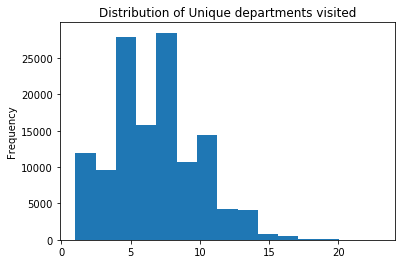

In [374]:
# number of unique department items for each trip
orders_df.groupby("trip_id").department_name.nunique().plot(kind = "hist", bins = 15)
plt.title("Distribution of Unique departments visited")
plt.show()

### 4. Number of items purchased by department

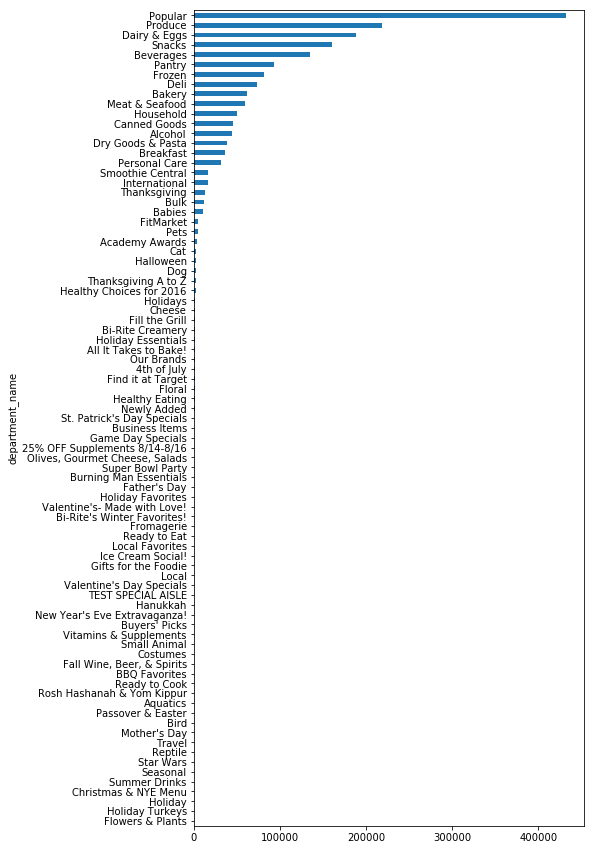

In [378]:
# Let's first identify the most popular departments for both train and test trips separately
orders_df[orders_df.data == "train"].groupby("department_name").item_id.count().sort_values().plot(kind = 'barh', figsize = (7,15))
plt.show()

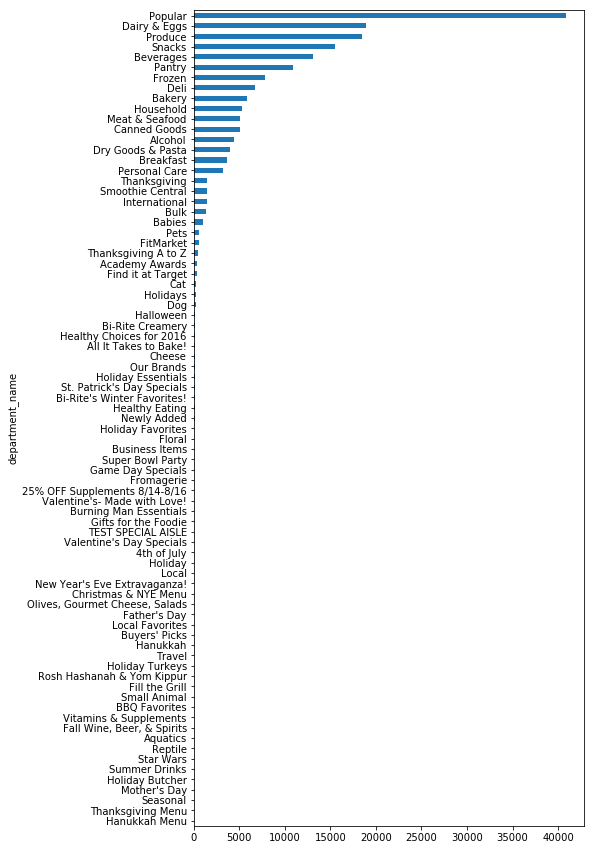

In [382]:
orders_df[orders_df.data == "test"].groupby("department_name").item_id.count().sort_values().plot(kind = 'barh', figsize = (7,15))
plt.show()

Some of these departments are specific to day and month, example: Christmas & NYE, Thanksgiving Menu, Hanukkah, etc.
We can combine some of these into one since they comprise a very low % of items purchased.

In [383]:
orders_df.groupby("department_name").item_id.count().sort_values(ascending = False)

department_name
Popular                         472826
Produce                         236651
Dairy & Eggs                    207164
Snacks                          175607
Beverages                       148023
Pantry                          103685
Frozen                           88966
Deli                             80243
Bakery                           67398
Meat & Seafood                   64377
Household                        54928
Canned Goods                     50456
Alcohol                          48245
Dry Goods & Pasta                42069
Breakfast                        39786
Personal Care                    34263
Smoothie Central                 17441
International                    17378
Thanksgiving                     13960
Bulk                             13407
Babies                           11999
FitMarket                         5931
Pets                              5831
Academy Awards                    4085
Cat                               2902
Halloween

In [384]:
# Getting the top 25 departments in terms of count of products purchased
top_deps = orders_df.groupby("department_name").item_id.count().sort_values(ascending = False)[:25]

# Getting common departments in train and test
common_deps = [dep for dep in orders_df[orders_df.data == "train"].department_name.unique()
 if dep in  orders_df[orders_df.data == "test"].department_name.unique() ]

In [385]:
train_df.head()

,trip_id,shopper_id,fulfillment_model,store_id,shopping_started_at,shopping_ended_at
0,3119519,48539,model_1,6,2015-09-01 07:03:56,2015-09-01 07:30:56
1,3119513,3775,model_1,1,2015-09-01 07:04:33,2015-09-01 07:40:33
2,3119516,4362,model_1,1,2015-09-01 07:23:21,2015-09-01 07:41:21
3,3119792,47659,model_1,1,2015-09-01 07:29:52,2015-09-01 08:55:52
4,3119922,11475,model_1,1,2015-09-01 07:32:21,2015-09-01 09:01:21


### 5. Let's look at the distribution of trip time and how it differs for different stores and fulfillment models 

In [386]:
train_df["trip_time"] = (train_df.shopping_ended_at - train_df.shopping_started_at).dt.seconds

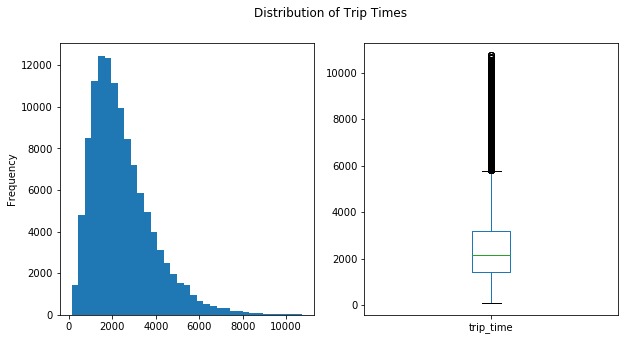

In [387]:
# Mumber of items per trip
fig = plt.figure(figsize=(10,5))

# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig.add_subplot(121)

# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig.add_subplot(122)

train_df["trip_time"].plot(kind = "hist", ax = ax1, bins = 35)
train_df["trip_time"].plot(kind = "box", ax = ax2)

fig.suptitle("Distribution of Trip Times")
plt.show()

The distribution is right skewed. We again observe many outliers but would are not distinctly greater than the rest of the datapoints. Therefor I will include these trips

In [388]:
print("Total number of stores:" ,train_df.store_id.nunique())

Total number of stores: 14


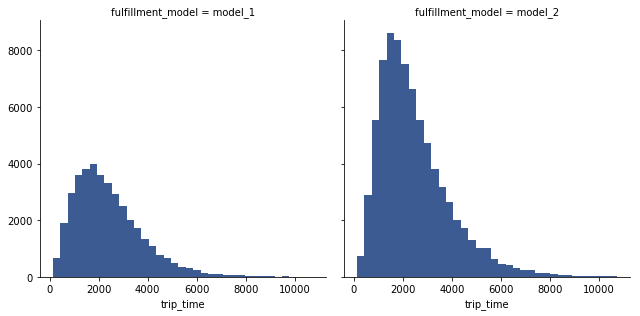

In [389]:
g = sns.FacetGrid(train_df, col="fulfillment_model",size = 4.5)
g.map(plt.hist, "trip_time", bins=35, color = sns.xkcd_rgb["denim blue"])
plt.show()

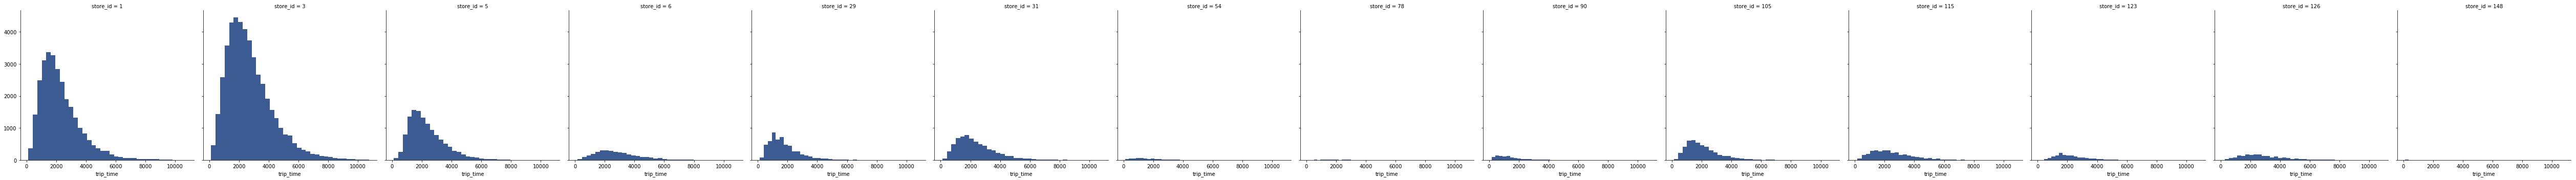

In [390]:
g = sns.FacetGrid(train_df, col="store_id", size = 5)
g.map(plt.hist, "trip_time", bins=35, color = sns.xkcd_rgb["denim blue"])
plt.show()

As we can see differences in the distribution of trip time with different fulfilment model and also store_type

### 6. Trip distribution by Shoppers

Number of shoppers:  1506


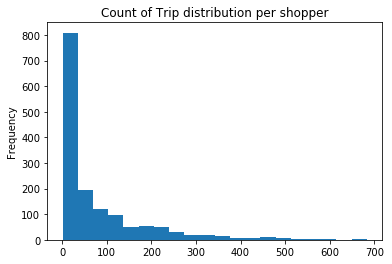

In [391]:
# number of trips by shopper
print("Number of shoppers: ", train_df.shopper_id.nunique())

train_df.groupby("shopper_id").trip_id.count().plot(kind = "hist", bins = 20)
plt.title("Count of Trip distribution per shopper")
plt.show()

## 3. Feature Engineering 

I will now start creating trip level features which are likely to influence the shoppers trip time. Here are the features I came up with:

**Using Orders data - Trip specific features**:
1. Number of items purchased per trip
2. Quantity of items per trip
3. Average quantity per item per trip
4. Number of different department items purchased per trip
5. Number of items purchased by department - this will create many features and make our feature vector very sparse. Might be a good idea to only consider top 25 departments
6. Quantity of items purchased by department - Same argument as 4

The above features can be created for the entire dataset at once since they are trip specific and trips are independent.

** Using Trips Data**
1. Trip Start Time based - Since we are given start time of the trip in the test data, we can use for feature creation
    * Hour of day
    * Day of week
    * Day of month 
2. Store-based features
    * Average trip time for a store
    * Number of trips for a store
    * Number of shoppers in a store 
3. Shopper-based features
    * Average trip time of shoppers previous N trips
    * Average trip time of shoppers all trips
    * Average trip time of shopper in a given store
    * Number of trips shopper made in a given store
    * Average number of items shopper buys
    * Average number of items shopper buys in a given store
4. Store_type using store_id
5. fulfillment_model 

Some of the features above need to be created carefully for test and train separately since we are aggregating accross trips and there can be information leakage.

Another important concern in features using average trip time is that when we do cross validation on train data there will be information leakage which we want to prevent. A feature transformer class needs to be built and passed in the make_pipeline function so that only train data is used for creating these features and are just transformed on the validation data. Considering time-constraints I was not able to work on this.


### 1. Feature Engineering - Using Orders Data (Trip Specific)

In [392]:
# Creating the first set of features which are trip specific
item_features_df = orders_df.groupby("trip_id").agg({"item_id":"count", "quantity":"sum", "department_name":pd.Series.nunique})
item_features_df.rename(columns={"item_id":"num_items_per_trip","quantity":"qty_items_per_trip","department_name":"num_deps_per_trip"}
                       ,inplace = True)
item_features_df.reset_index(inplace=True)

# creating feature 5 - Some departments might not be visited in many trips which results in Nans. They can be replaced with 0
num_items_by_dep_df = orders_df.groupby(["trip_id","department_name"]).item_id.count().to_frame().unstack(level = 1).fillna(0)
num_items_by_dep_df.columns = num_items_by_dep_df.columns.droplevel()
num_items_by_dep_df.reset_index(inplace=True)
num_items_by_dep_df = num_items_by_dep_df.filter(items = ["trip_id"] + list(top_deps.index))
# num_items_by_dep_df = num_items_by_dep_df.filter(items = ["trip_id"] + common_deps)


# creating feature 6 
qty_items_by_dep_df = orders_df.groupby(["trip_id","department_name"]).quantity.sum().to_frame().unstack(level = 1).fillna(0)
qty_items_by_dep_df.columns = qty_items_by_dep_df.columns.droplevel()
qty_items_by_dep_df.reset_index(inplace=True)
qty_items_by_dep_df = qty_items_by_dep_df.filter(items = ["trip_id"] + list(top_deps.index))
# qty_items_by_dep_df = qty_items_by_dep_df.filter(items = ["trip_id"] + common_deps)


In [393]:
print(item_features_df.shape)
print(num_items_by_dep_df.shape)
print(qty_items_by_dep_df.shape)

(128710, 4)
(128710, 26)
(128710, 26)


Combining all the features created using the orders dataset into one. This dataset is unique at trip_id level

In [394]:
dfs = [item_features_df,num_items_by_dep_df,qty_items_by_dep_df]
order_features_all = reduce(lambda left,right: pd.merge(left,right,on='trip_id',suffixes=("_num_items","_qty_items")), dfs)

In [395]:
# Creating feature - 4
order_features_all["avg_qty_per_item_per_trip"] = order_features_all.qty_items_per_trip/order_features_all.num_items_per_trip

In [396]:
# Adding these features created to training and testing data
train_final_df = pd.merge(order_features_all, train_df)
test_final_df = pd.merge(order_features_all, test_df)

Before we move on to creating the next set of features let's look at some scatter plots from the full training data before we divide split it into holdout + training.

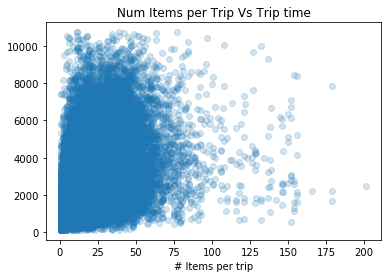

In [397]:
# correlation plots
plt.scatter(train_final_df.num_items_per_trip,train_final_df.trip_time, alpha = 0.2)
plt.title("Num Items per Trip Vs Trip time")
plt.xlabel("# Items per trip")
plt.show()

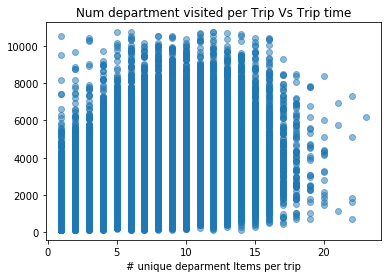

In [398]:
plt.scatter(train_final_df.num_deps_per_trip,train_final_df.trip_time, alpha = 0.5)
plt.title("Num department visited per Trip Vs Trip time")
plt.xlabel("# unique deparment Items per trip")
plt.show()

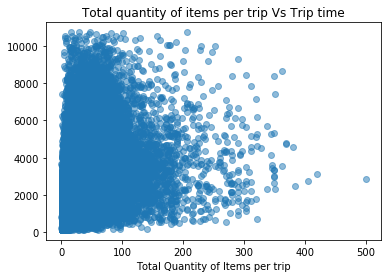

In [399]:
plt.scatter(train_final_df.qty_items_per_trip,train_final_df.trip_time, alpha = 0.5)
plt.title("Total quantity of items per trip Vs Trip time")
plt.xlabel("Total Quantity of Items per trip")
plt.show()

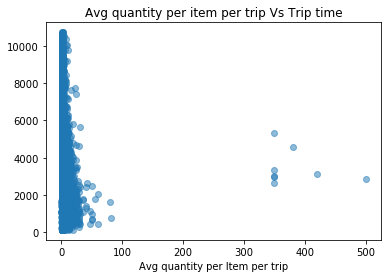

In [400]:
plt.scatter(train_final_df.avg_qty_per_item_per_trip,train_final_df.trip_time, alpha = 0.5)
plt.title("Avg quantity per item per trip Vs Trip time")
plt.xlabel("Avg quantity per Item per trip")
plt.show()

We can see there are a few outliers here. The average quantity per item per trip is very large for 7 trips. We can remove these trips. It might improve our model performance.

In [401]:
len(train_final_df.filter(like = "num_items").columns)

26

### trip_time vs num of items purchased by department

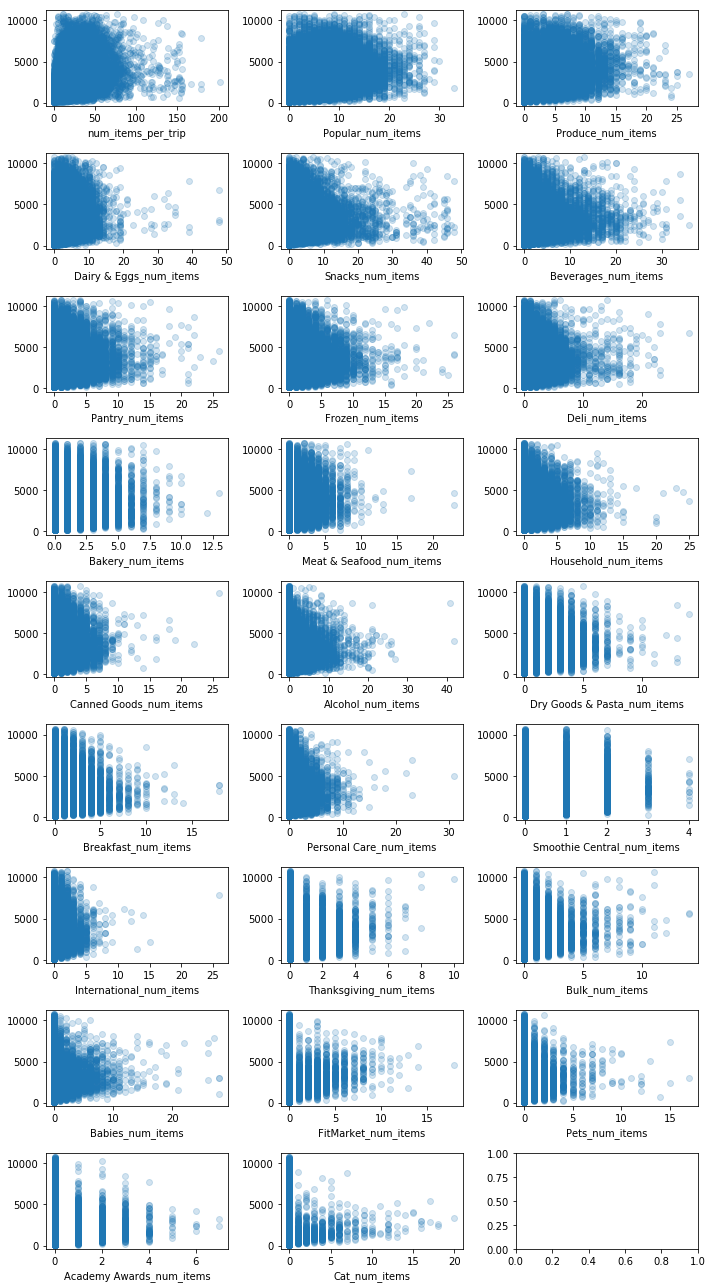

In [402]:
fig, axes = plt.subplots(9, 3, figsize=(10, 18))

for i, col in enumerate(train_final_df.filter(like = "num_items").columns):
    ax = axes[int((i-i%3)/3),i%3]
    ax.scatter(train_final_df[col],train_final_df.trip_time,alpha=0.2)
    ax.set_xlabel(col)
    
plt.tight_layout()
plt.show()

### trip_time vs quantity of items purchased by department

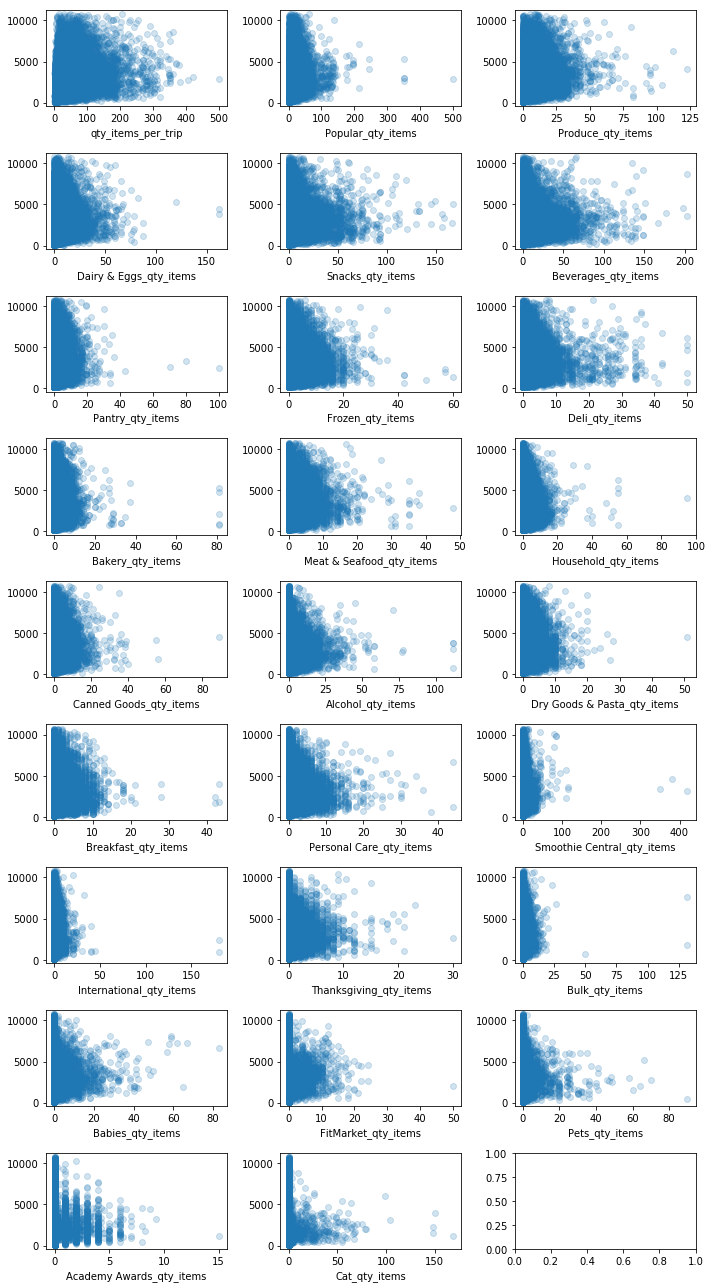

In [403]:
fig, axes = plt.subplots(9, 3, figsize=(10, 18))

for i, col in enumerate(train_final_df.filter(like = "qty_items").columns):
    ax = axes[int((i-i%3)/3),i%3]
    ax.scatter(train_final_df[col],train_final_df.trip_time,alpha=0.2)
    ax.set_xlabel(col)
    
plt.tight_layout()
plt.show()

Let go back to creating our second set of features

We should now split the training data into further training and hold-out set. The holdout set will help us evaluate our model

In [404]:
X_train,X_hold,y_train,y_hold = train_test_split(train_final_df.drop(labels="trip_time", axis = 1), train_final_df[["trip_time"]], test_size = 0.3)

Let's now write a function that created the next set of features given the training and testing dataset. Modularizing our code helps us here since we have to create features for train and hold out following for full train and test. 

In [405]:
def create_features(X_train,y_train,X_hold):
    
    # TIME BASED
    X_train["trip_start_dow"] = X_train.shopping_started_at.dt.dayofweek
    X_hold["trip_start_dow"] = X_hold.shopping_started_at.dt.dayofweek


    X_train["trip_start_hour_of_day"] = X_train.shopping_started_at.dt.hour
    X_hold["trip_start_hour_of_day"] = X_hold.shopping_started_at.dt.hour

    X_train["trip_start_day_of_month"] = X_train.shopping_started_at.dt.day
    X_hold["trip_start_day_of_month"] = X_hold.shopping_started_at.dt.hour
    
    # For simplicity, I am keeping X and y in the same dataset for training and holdout. 
    train = pd.merge(X_train, y_train, left_index = True, right_index=True)
    holdout = X_hold
    
    #### 1. SHOPPER BASED ####
    ##### b. Average trip time for a shopper in all the previous trips #####
    
    train = pd.merge(train, train.groupby("shopper_id")["trip_time"].mean().to_frame(),
         left_on="shopper_id", right_index=True,suffixes = ("","_avg_shopper"))

    # Creating same feature on test - here we do a left join since some shoppers are in test but not in train data
    holdout = holdout.merge(train.groupby("shopper_id")["trip_time"].mean().to_frame(),
                                       left_on = "shopper_id", right_index = True, how = "left")
    
    holdout.rename(columns={"trip_time":"trip_time_avg_shopper"}, inplace=True)

    # For remaining shoppers we impute with mean
    def impute(df,col_name):

        mean_val = np.mean(df[col_name])
        df.fillna(mean_val, inplace=True)
        return df

    holdout = impute(holdout,"trip_time_avg_shopper")
    
    #### c. Number of previous trips the shopper has done in that store #####

    train = train.merge(   train.groupby(["shopper_id","store_id"])
                                .trip_id.count().to_frame().reset_index()
                                .rename(columns = {"trip_id":"num_trips_shopper_store"})
                                )

    holdout = holdout.merge(    holdout.groupby(["shopper_id","store_id"]).
                                trip_id.count().to_frame().reset_index()
                                .rename(columns = {"trip_id":"num_trips_shopper_store"})
                                )

    #### d. Average trip time of shopper in a given store ####
    
    train = train.merge(train.groupby(["shopper_id","store_id"])["trip_time"].mean().to_frame(),
                                  left_on=["shopper_id","store_id"], right_index=True,suffixes = ("","_avg_shopper_by_store"))
    
    holdout = holdout.merge(train.groupby(["shopper_id","store_id"])["trip_time"].mean().to_frame(),
                                  left_on=["shopper_id","store_id"], right_index=True, how = "left")
    
    holdout.rename(columns={"trip_time":"trip_time_avg_shopper_by_store"}, inplace=True)
    holdout = impute(holdout,"trip_time_avg_shopper_by_store")
    
    #### e. Average number of items the shopper buys ####
    
    train = train.merge((orders_df.merge(train).groupby("shopper_id").item_id.count() / orders_df.merge(train).groupby("shopper_id").trip_id.nunique()).to_frame(),
                  left_on = "shopper_id", right_index = True)
    train.rename(columns={0:"avg_num_items_by_shopper"}, inplace=True)
    holdout = holdout.merge((orders_df.merge(holdout).groupby("shopper_id").item_id.count() / orders_df.merge(holdout).groupby("shopper_id").trip_id.nunique()).to_frame(),
                  left_on = "shopper_id", right_index = True)
    holdout.rename(columns={0:"avg_num_items_by_shopper"}, inplace=True)
    
    #### f. Average number of items shopper buys in a given store ####
    
    train = train.merge((orders_df.merge(train).groupby(["shopper_id","store_id"]).item_id.count() / orders_df.merge(train).groupby(["shopper_id","store_id"]).trip_id.nunique()).to_frame(),
                  left_on = ["shopper_id","store_id"], right_index = True)
    train.rename(columns={0:"avg_num_items_by_shopper_store"}, inplace=True)
    
    holdout = holdout.merge((orders_df.merge(holdout).groupby(["shopper_id","store_id"]).item_id.count() / orders_df.merge(holdout).groupby(["shopper_id","store_id"]).trip_id.nunique()).to_frame(),
                  left_on = ["shopper_id","store_id"], right_index = True)
    holdout.rename(columns={0:"avg_num_items_by_shopper_store"}, inplace=True)
    
    ### 2. STORE - BASED ###
    
    #### a. Average trip time for a store ####
    
    train = train.merge(train.groupby("store_id").trip_time.mean().to_frame(),
                                left_on="store_id", right_index=True
                               ,suffixes = ("","_avg_store"))
    
    holdout = holdout.merge(train.groupby("store_id").trip_time.mean().to_frame(),
                                left_on="store_id", right_index=True
                               , how = "left")
    
    holdout.rename(columns={"trip_time":"trip_time_avg_store"}, inplace=True)
    holdout = impute(holdout,"trip_time_avg_store")
    
    #### b. Total trips for the store
    
    train = train.merge(train.groupby("store_id").trip_id.count().to_frame().reset_index()
                                .rename(columns = {"trip_id":"num_trips_by_store"})
                  ,left_on = "store_id",right_on = "store_id"
                 )
    
    holdout =  holdout.merge(holdout.groupby("store_id").trip_id.count().to_frame().reset_index()
                                .rename(columns = {"trip_id":"num_trips_by_store"})
                  ,left_on = "store_id",right_on = "store_id"
                 )
    
    #### c. Number of shoppers in the store
    
    train = train.merge(train.groupby("store_id").shopper_id.nunique().to_frame().reset_index()
                                .rename(columns = {"shopper_id":"num_shoppers_by_store"}),
                               left_on = "store_id",right_on = "store_id")
    
    holdout = holdout.merge(holdout.groupby("store_id").shopper_id.nunique().to_frame().reset_index()
                                .rename(columns = {"shopper_id":"num_shoppers_by_store"}),
                               left_on = "store_id",right_on = "store_id")
    
    # Creating dummies and including only the ones present in both datasets
    
    # first get convert all categorical variable to data type "category"
    
    train["store_id"] = train.store_id.astype("category")
    train["fulfillment_model"] = train.fulfillment_model.astype("category")
    train['trip_start_dow'] = train.trip_start_dow.astype("category")
    train['trip_start_hour_of_day'] = train.trip_start_hour_of_day.astype("category")
    train['trip_start_day_of_month'] = train.trip_start_day_of_month.astype("category")

    holdout["store_id"] = holdout.store_id.astype("category")
    holdout["fulfillment_model"] = holdout.fulfillment_model.astype("category")
    holdout['trip_start_dow'] = holdout.trip_start_dow.astype("category")
    holdout['trip_start_hour_of_day'] = holdout.trip_start_hour_of_day.astype("category")
    holdout['trip_start_day_of_month'] = holdout.trip_start_day_of_month.astype("category")

    float_cols = ["num_items_per_trip","qty_items_per_trip","num_deps_per_trip","num_trips_by_store","num_shoppers_by_store","num_trips_shopper_store"]
    
    for col in float_cols:
        train[col] = train[col].astype(float)
        holdout[col] = holdout[col].astype(float)
        
        
    train_w_dummies = pd.get_dummies(train)
    holdout_w_dummies = pd.get_dummies(holdout)
    
    cols_drop = [col for col in train_w_dummies.select_dtypes(['uint8']).columns 
                 if col not in holdout_w_dummies.select_dtypes(['uint8']).columns] 
    
    return train_w_dummies.drop(labels=cols_drop + ["trip_time"], axis = 1), holdout_w_dummies
    



In [406]:
X_train_w_featuers, X_hold_w_features = create_features(X_train,y_train,X_hold)

In [407]:
# Since we have done a lot of reset index, we should reindex X_train_w_features as per X_train and similarly
# X_hold_w_features with X_hold

X_train.set_index("trip_id", inplace=True)
X_train_w_featuers.set_index("trip_id", inplace=True)
X_train_w_featuers = X_train_w_featuers.reindex(X_train.index)

X_hold.set_index("trip_id", inplace=True)
X_hold_w_features.set_index("trip_id", inplace=True)
X_hold_w_features = X_hold_w_features.reindex(X_hold.index)

In [408]:
y_train = y_train.astype(float)


In [409]:
y_hold = y_hold.astype(float)

In [410]:
X_hold_w_features.drop(labels = list(X_hold_w_features.select_dtypes(["<M8[ns]"]).columns) , inplace = True, axis = 1)
X_train_w_featuers.drop(labels = list(X_train_w_featuers.select_dtypes(["<M8[ns]"]).columns) , inplace = True, axis = 1)

In [411]:
X_train_w_featuers.shape

(81944, 120)

In [412]:
X_hold_w_features.shape

(35119, 120)

## Predictive Models

### 1. Linear models

First I will try a set of linear models:
1. Linear Regression
2. Ridge Regression 
3. Lasso Regression 
4. Eastic Net Regresssion

Will tune the hyper-parameters using cross-validation in order to build a generalizable model.

In [290]:
ols_pipe = make_pipeline(RobustScaler(), LinearRegression())
ridge_pipe = make_pipeline(RobustScaler(), Ridge())
lasso_pipe = make_pipeline(RobustScaler(), Lasso(max_iter = 10000))
elastic_pipe = make_pipeline(RobustScaler(), ElasticNet(max_iter = 50000))

In [292]:
def model_summary(X_train,y_train,X_test,y_test, pipe, param_grid):
    grid = GridSearchCV(pipe, param_grid, cv = 3, scoring='neg_mean_absolute_error')
    grid.fit(X_train, y_train)
    print("Best params obtained from grid search: ",grid.best_params_)
    print("\n")
    print("Best cross-val score: ", grid.best_score_)

    best_model = grid.best_estimator_.fit(X_train,y_train)
    y_pred = best_model.predict(X_test)
    print("Mean absolute error on holdout:" , mean_absolute_error(y_test,y_pred))
    

#### a. LASSO PIPE - L1 REGULARIZATION

In [294]:
param_grid = {'lasso__alpha':np.logspace(-2,3,4)}
model_summary(X_train_w_featuers,y_train, X_hold_w_features, y_hold, lasso_pipe, param_grid)

Best params obtained from grid search:  {'lasso__alpha': 0.46415888336127797}


Best cross-val score:  -735.966609779
Mean absolute error on holdout: 838.313551143


#### b. RIDGE PIPE - L2 REGULARIZATION

In [293]:
param_grid = {'ridge__alpha':np.logspace(1,4,5)}
model_summary(X_train_w_featuers,y_train, X_hold_w_features, y_hold, ridge_pipe, param_grid)

Best params obtained from grid search:  {'ridge__alpha': 316.22776601683796}


Best cross-val score:  -736.034299486
Mean absolute error on holdout: 835.010147149


#### c. Elastic Net Pipe - L1 + L2 REGULARIZATION

In [289]:
param_grid = {'elasticnet__alpha':[0.1,10,100],
             'elasticnet__l1_ratio':[ 0.1, 10,100]}
grid = GridSearchCV(elastic_pipe, param_grid, cv = 3, scoring = 'neg_mean_absolute_error')

grid.fit(X_train_w_featuers, y_train)
print(grid.best_params_)
print("Best cross-val score: ", grid.best_score_)

best_model = grid.best_estimator_.fit(X_train_w_featuers,y_train)

y_pred = best_model.predict(X_hold_w_features)

mean_absolute_error(y_hold,y_pred)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1}
Best cross-val score:  -743.066670639


817.89021968531085

Among the linear models we can see that the Elastic Net performs the best with a MAE of 817 seconds on the holdout set

### 2. Non-Linear Models

I will try the following models
1. RandomForestRegressor
2. GradientBoostingRegressor
3. XGBoosting regressor

In [296]:
rf_pipe = make_pipeline(RandomForestRegressor(n_estimators=50,n_jobs=-1))
gbr_pipe = make_pipeline(GradientBoostingRegressor(max_depth = 7,learning_rate = 0.05))

In [303]:
param_grid = {'randomforestregressor__max_depth': [5,7,10]}
model_summary(X_train_w_featuers,y_train.values.ravel(), X_hold_w_features, y_hold.values.ravel(), rf_pipe, param_grid)

Best params obtained from grid search:  {'randomforestregressor__max_depth': 10}


Best cross-val score:  -715.301958669
Mean absolute error on holdout: 808.045196555


In [304]:
param_grid = {'gradientboostingregressor__max_features': ['auto']}
model_summary(X_train_w_featuers,y_train.values.ravel(), X_hold_w_features, y_hold.values.ravel(), gbr_pipe, param_grid)

Best params obtained from grid search:  {'gradientboostingregressor__max_features': 'auto'}


Best cross-val score:  -694.520371704
Mean absolute error on holdout: 792.296733295


As seen above my best score on the hold-out is obtained using Gradient Boosting Regressor. A mean absolute error of 792.3 secs.
I will use this model to fit on the entire training data and make predictions on the given test set

## Test Set Predictions

In [305]:
X_train_full_w_feat, X_test_full_w_feat = create_features(train_final_df.drop(labels="trip_time", axis = 1), train_final_df[["trip_time"]], test_final_df)

In [308]:
# Since we have done a lot of reset index, we should reindex X_train_w_features as per X_train and similarly

train_final_df.set_index("trip_id", inplace=True)
X_train_full_w_feat.set_index("trip_id", inplace=True)
X_train_full_w_feat = X_train_full_w_feat.reindex(train_final_df.index)

test_final_df.set_index("trip_id", inplace=True)
X_test_full_w_feat.set_index("trip_id", inplace=True)
X_test_full_w_feat = X_test_full_w_feat.reindex(test_final_df.index)

In [310]:
X_test_full_w_feat.drop(labels = list(X_test_full_w_feat.select_dtypes(["<M8[ns]"]).columns) , inplace = True, axis = 1)
X_train_full_w_feat.drop(labels = list(X_train_full_w_feat.select_dtypes(["<M8[ns]"]).columns) , inplace = True, axis = 1)

In [311]:
y_train_full = train_final_df.trip_time.astype(float)

In [349]:
# making sure our index is aligned
sum(train_final_df.index.values == X_train_full_w_feat.index.values) == train_final_df.shape[0]

True

In [318]:
gbr_final = GradientBoostingRegressor(max_depth = 7,learning_rate = 0.05, max_features='auto')
gbr_final.fit(X_train_full_w_feat,y_train_full)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=7,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [321]:
predictions_final = gbr_final.predict(X_test_full_w_feat)

In [337]:
X_test_full_w_feat["shopping_time"] = predictions_final 

In [353]:
X_test_full_w_feat.shopping_time.to_csv("../output/output1.csv", header = True)

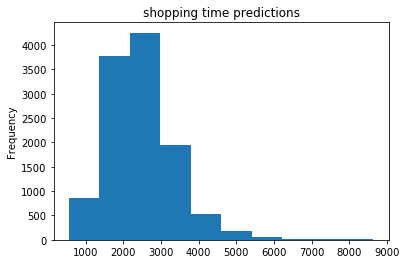

In [351]:
X_test_full_w_feat.shopping_time.plot(kind = "hist")
plt.title("shopping time predictions")
plt.show()

## Feature Importances

In [341]:
feat_importance_data = pd.DataFrame()
feat_importance_data["labels"] = X_train_full_w_feat.columns
feat_importance_data["importances"] = gbr_final.feature_importances_
feat_importance_data.set_index("labels", inplace=True)


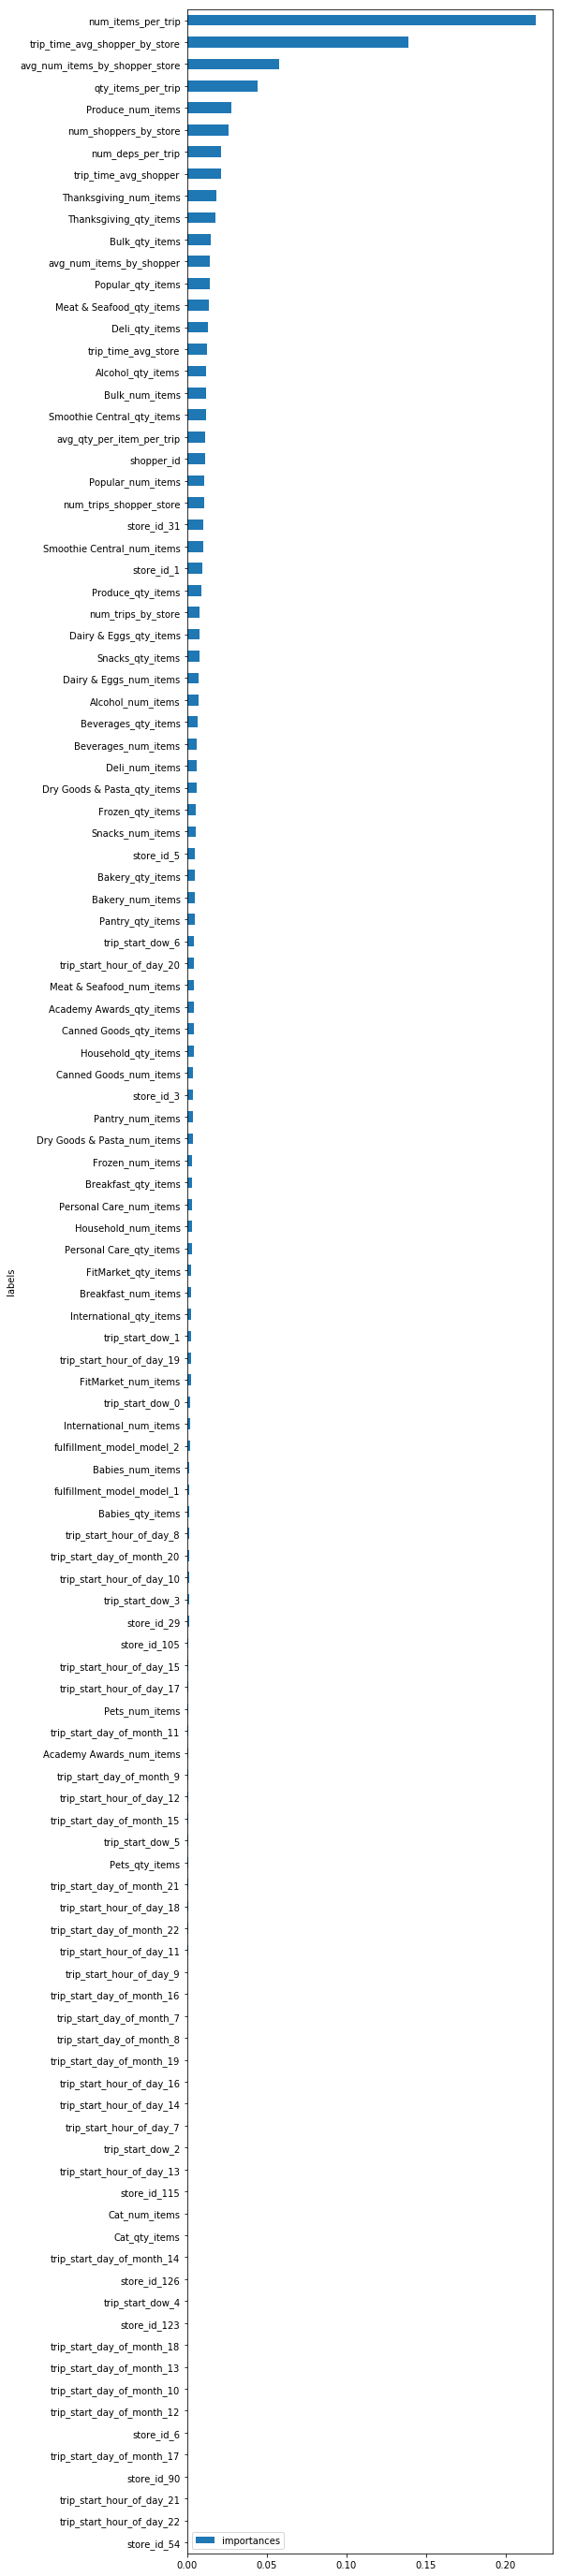

In [348]:

feat_importance_data.sort_values("importances").plot(kind = 'barh', figsize = (7,50));

## Discussion:

From the above plot we can see that the number of items per trip, avg trip time of shopper within store, average number of items by shopper and store and most important features. 

The time based features are not very important. Although I assumed that at certain times the store would be more crowded than others which would lead to longer trip times.



## Challenges and Concerns

1. Avoiding information leakage: Certain features that we have created are based on trip time(dependent variable) and therefore our cross-validation suffers from infomration leak happening since these features are fit on the entire data used for cross validation. To avoid this problem, we would need to create a class with fit and transform methods and pass in into the make_pipeline method along with the Regressor.

2. Some features are such that their categories are present in the training data and absent in the test or vice versa. Example:
    We calculated the average trip time for shoppers by store and used it in the train data but some shoppers in the test data are new and therefore they would nt have an avg trip time by store. I have imputed shoppers with the mean value of the trip_time accross all shoppers.
    
3. The model take long time to train on my machine which was a limitation and I could not experiment much. The outlier trips I found based on qty per item per trip can be removed (data points) and our model can be re-assessed. 
    


## Evaluation Metrics

The model is evaluated based on hold-out set score. First hyper-parameter tuning is done using GridSearch and k-fold cross validation. For scoring purposes **mean abolute error** is being used. These metrics give us a better sense of the performance since we know how much are we deviating from the expected trip time. Root mean squared error is highly impacted by outliers and punishes large deviations greatly compared to mean absolute error.